<a href="https://colab.research.google.com/github/cometku/SEESMosquitoMappers/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model, load_model

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import BatchNormalization, Dense, Flatten
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: ignored

In [ ]:
#we will change these

base_path = r'C:\Users\VivekKuleen\Downloads\New Plots\plots_AI'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [ ]:
categories = [f.name for f in os.scandir(train_path) if os.path.isdir(f)]
categories

['Bare Ground',
 'Building',
 'Bush_or_Scrub',
 'Cultivated Vegetation',
 'Grass',
 'Impervious Surface (No Building)',
 'Trees_Canopycover',
 'Water']

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(
    train_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=20
)
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)
test_batches = ImageDataGenerator().flow_from_directory(
    test_path,
    target_size=(128, 128),
    classes=categories,
    batch_size=10
)

Found 6661 images belonging to 8 classes.
Found 1325 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


In [ ]:
vgg16_model = applications.vgg16.VGG16(include_top=False, input_shape=(128,128,3))

In [ ]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
    if "pool" in layer.name:
        model.add(BatchNormalization())

In [ ]:
NUM_TRAINABLE_LAYERS = len(vgg16_model.layers) - 3
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

In [ ]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

In [ ]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = load_model(r'C:\Users\VivekKuleen\Desktop\Important\best_vgg16_model.h5')

In [ ]:
checkpoint = ModelCheckpoint(

    r'C:\Users\VivekKuleen\Desktop\Important\best_vgg16_model2.h5',
    save_best_only=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    factor = 0.25,
    patience = 3,
    min_delta = 0.001,
    verbose = 1
)
early_stop = EarlyStopping(
    min_delta = 0.0005,
    patience = 5,
    verbose = 1
)

In [ ]:
history = model.fit(
    train_batches,
    steps_per_epoch=333,
    validation_data=valid_batches,
    validation_steps=132,
    epochs=25,
    callbacks = [checkpoint, reduce_lr, early_stop],
    verbose=1
)
#steps_per_epoch=184
#validation_steps=73

Epoch 1/25
333/333 [==============================] - ETA: 0s - loss: 0.8438 - accuracy: 0.7353
Epoch 00001: val_loss improved from inf to 0.53648, saving model to C:\Users\VivekKuleen\Desktop\Important\best_vgg16_model2.h5
333/333 [==============================] - 698s 2s/step - loss: 0.8438 - accuracy: 0.7353 - val_loss: 0.5365 - val_accuracy: 0.8227
Epoch 2/25
333/333 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.7851
Epoch 00002: val_loss improved from 0.53648 to 0.45838, saving model to C:\Users\VivekKuleen\Desktop\Important\best_vgg16_model2.h5
333/333 [==============================] - 685s 2s/step - loss: 0.6142 - accuracy: 0.7851 - val_loss: 0.4584 - val_accuracy: 0.8295
Epoch 3/25
333/333 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.8104
Epoch 00003: val_loss did not improve from 0.45838
333/333 [==============================] - 678s 2s/step - loss: 0.5497 - accuracy: 0.8104 - val_loss: 0.4813 - val_accuracy: 0.8455
Epoch

In [ ]:
model.save(r'C:\Users\VivekKuleen\Desktop\Important\final_vgg16_model2.h5')

In [ ]:
import pickle as pkl
with open(r'C:\Users\VivekKuleen\Desktop\Important\vgg16_history2', 'wb') as hist:
    pkl.dump(history.history, hist)

In [ ]:
def plot_history(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

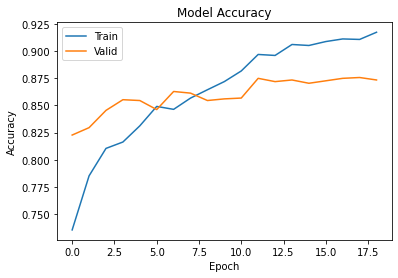

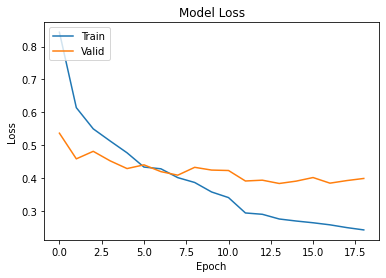

In [ ]:
plot_history(history)

In [ ]:
predictions = model.predict(test_batches, steps=270, verbose=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')


In [ ]:
def test_generator(test_dir, target_size):
    for f in os.scandir(test_dir):
        if os.path.isfile(f):
            im = cv2.imread(f.path)
            yield np.expand_dims(cv2.resize(im, target_size), 0)

In [ ]:
import cv2
test_batches = test_generator(test_path, (128, 128))

In [ ]:
!pip install opencv-python

In [ ]:
predictions = model.predict(test_batches, verbose=1)

891/891 [==============================] - 40s 45ms/step


In [ ]:
import pandas as pd

csv = pd.read_csv(r'C:\Users\VivekKuleen\Downloads\New Plots\plots_AI\test_csv.csv')
cats = csv['category']

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

true = LabelEncoder().fit_transform(cats)

In [ ]:
accuracy_score(true, np.argmax(predictions, -1))

0.20202020202020202

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, np.argmax(predictions, -1))

Confusion matrix, without normalization
[[ 29   6  14   6   0  46  10   9]
 [ 29   1  17   0   0   0  11  10]
 [ 10   2  50  18  10  10  31  15]
 [  0  11   2   1   6  11   4  15]
 [  1   6   0   7   1   7   3   5]
 [  3  13   3  17   7  33  38   9]
 [ 76   3  23  17   0   1  51  18]
 [121   0   4  24   0   0   2  14]]


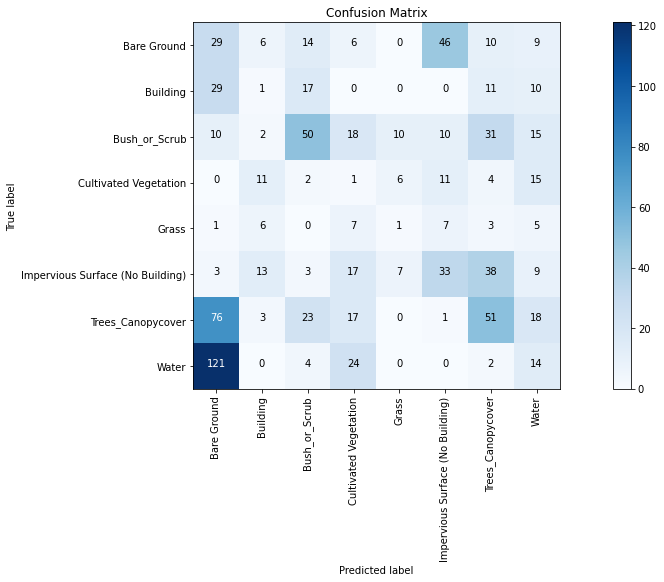

In [ ]:
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")